# 1. Setup

## 1.1 Install Dependencies

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394.3 MB 9.9 kB/s 
     |████████████████████████████████| 394.3 MB 16 kB/s 
     |████████████████████████████████| 132 kB 74.8 MB/s 
     |████████████████████████████████| 2.9 MB 44.0 MB/s 
     |████████████████████████████████| 462 kB 69.6 MB/s 
     |████████████████████████████████| 14.8 MB 60.9 MB/s 
     |████████████████████████████████| 3.8 MB 58.0 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68721 sha256=916702ffdbc9a03fddd79d2ad448592382fc1d8bf85d5b576cd6ac7e7a99706c
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Att

## 1.2 Import Dependencies

In [ ]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import shutil
from IPython.display import Image
import uuid
import posix
import glob

In [ ]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

# Connect G.Drive

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


## 1.3 Set GPU Growth

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [ ]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
print(POS_PATH)

data/positive


In [ ]:
import glob
print(glob.glob(os.path.join('/content/sample_data','*.csv')))


['/content/sample_data/mnist_test.csv', '/content/sample_data/california_housing_train.csv', '/content/sample_data/mnist_train_small.csv', '/content/sample_data/california_housing_test.csv']


# 2. Collect Positives and Anchors

## 2.1 Collect Negative Images 

In [ ]:

count=0
dir_path=r'/content/drive/MyDrive/Colab Notebooks/lfw_home/lfw_funneled'
for directory in os.listdir(dir_path):
  #print(directory)
  imgpath=os.path.join(dir_path,directory)
  #print(imgpath)
  
  for file in glob.iglob(os.path.join(imgpath,"*jpg")):
    shutil.copy(file,NEG_PATH)
    count=count+1
      
    print(f"{count} image copied")
     
  if count>=250:
    print('no')
    break; 
    
    
   

1 image copied
2 image copied
3 image copied
4 image copied
5 image copied
6 image copied
7 image copied
8 image copied
9 image copied
10 image copied
11 image copied
12 image copied
13 image copied
14 image copied
15 image copied
16 image copied
17 image copied
18 image copied
19 image copied
20 image copied
21 image copied
22 image copied
23 image copied
24 image copied
25 image copied
26 image copied
27 image copied
28 image copied
29 image copied
30 image copied
31 image copied
32 image copied
33 image copied
34 image copied
35 image copied
36 image copied
37 image copied
38 image copied
39 image copied
40 image copied
41 image copied
42 image copied
43 image copied
44 image copied
45 image copied
46 image copied
47 image copied
48 image copied
49 image copied
50 image copied
51 image copied
52 image copied
53 image copied
54 image copied
55 image copied
56 image copied
57 image copied
58 image copied
59 image copied
60 image copied
61 image copied
62 image copied
63 image copied
6

## 2.2 Collect Positive and Anchor Classes

### Web Cam import

In [ ]:
#@ js_to_data function

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  #Resize image

   # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, 1)



  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes


In [ ]:

def take_photo(filename= '{}.jpg'.format(uuid.uuid1()), quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
 

 # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image and resize it to (250,250)
  img = cv2.resize((js_to_image(data)),(250,250))
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

  # save image as anchor
  user_input = input("To save as anchor press a or press p to save as positive\n")
  print('Pressed key:',user_input)
  if user_input== 'a':
    img_path=os.path.join(ANC_PATH,filename)
    cv2.imwrite(img_path, img)
  else:
    img_path=os.path.join(POS_PATH,filename)
    cv2.imwrite(img_path, img)

  return filename

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
from traitlets.traitlets import TraitType
from numpy.lib import type_check

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(str,filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

To save as anchor press a or press p to save as positive
p
Pressed key: p
Saved to d589ab92-415f-11ed-8b8f-0242ac1c0002.jpg


In [ ]:
#Eslablish connection to the webcam
cap=cv2.VideoCapture(3)
while cap.isOpened():
  ret, frame=cap.read()
  #Show Image

  cv2.imshow('Image collection', frame)

  #Breaking gracefully
  if cv2.wait(1) & 0XFF == ord('q'):
    break
#release the webcam
cap.release()
cv2.destroyAllWindows()

In [ ]:
#Move Positive images

count=0
dir_path=r'/content/drive/MyDrive/Pos'
for directory in os.listdir(dir_path):
  #print(directory)
  imgpath=os.path.join(dir_path,directory)
  #print(imgpath)
  shutil.copy(imgpath,POS_PATH)
  count=count+1
  print(f"{count} images copied")

  

1 images copied
2 images copied
3 images copied
4 images copied
5 images copied
6 images copied
7 images copied
8 images copied
9 images copied
10 images copied
11 images copied
12 images copied
13 images copied
14 images copied
15 images copied
16 images copied
17 images copied
18 images copied
19 images copied
20 images copied
21 images copied
22 images copied
23 images copied
24 images copied
25 images copied
26 images copied
27 images copied
28 images copied
29 images copied
30 images copied
31 images copied
32 images copied
33 images copied
34 images copied
35 images copied
36 images copied
37 images copied
38 images copied
39 images copied
40 images copied
41 images copied
42 images copied
43 images copied
44 images copied
45 images copied
46 images copied
47 images copied
48 images copied
49 images copied
50 images copied
51 images copied
52 images copied
53 images copied
54 images copied
55 images copied
56 images copied
57 images copied
58 images copied
59 images copied
60 ima

In [ ]:
#Move Anchor images

count=0
dir_path=r'/content/drive/MyDrive/Arc'
for directory in os.listdir(dir_path):
  #print(directory)
  imgpath=os.path.join(dir_path,directory)
  #print(imgpath)
  shutil.copy(imgpath,ANC_PATH)
  count=count+1
  print(f"{count} images copied")

1 images copied
2 images copied
3 images copied
4 images copied
5 images copied
6 images copied
7 images copied
8 images copied
9 images copied
10 images copied
11 images copied
12 images copied
13 images copied
14 images copied
15 images copied
16 images copied
17 images copied
18 images copied
19 images copied
20 images copied
21 images copied
22 images copied
23 images copied
24 images copied
25 images copied
26 images copied
27 images copied
28 images copied
29 images copied
30 images copied
31 images copied
32 images copied
33 images copied
34 images copied
35 images copied
36 images copied
37 images copied
38 images copied
39 images copied
40 images copied
41 images copied
42 images copied
43 images copied
44 images copied
45 images copied
46 images copied
47 images copied
48 images copied
49 images copied
50 images copied
51 images copied
52 images copied
53 images copied
54 images copied
55 images copied
56 images copied
57 images copied
58 images copied
59 images copied
60 ima

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [ ]:
anchor=tf.data.Dataset.list_files(ANC_PATH+'/*jpg').take(199)
positive= tf.data.Dataset.list_files(POS_PATH+'/*jpg').take(199)
negative= tf.data.Dataset.list_files(NEG_PATH+'/*jpg').take(199)

In [ ]:
#Test the tf.data

test_dir=anchor.as_numpy_iterator()
print(test_dir.next())

b'data/anchor/03138d15-3833-11ed-9e6d-f0038cc82e1e.jpg'


## 3.2 Preprocessing - Scale and Resize

In [ ]:
#

def preprocess(file_path):
  #read in from the file_path
  byte_image= tf.io.read_file(file_path)
  # Load in the image
  img=tf.io.decode_jpeg(byte_image)
  #preprocessing steps - resizing the image to be 100x100x3
  img=tf.image.resize(img,(105,105))
  #Scale image to be 0 and 1
  img= img/255
  
  return img
   


In [ ]:
img=preprocess('data/anchor/fb26ac56-3832-11ed-a9a1-f0038cc82e1e.jpg')

In [ ]:
print(img)

tf.Tensor(
[[[0.6404295  0.66003734 0.67180204]
  [0.64863944 0.6682473  0.680012  ]
  [0.65910363 0.6787115  0.6904762 ]
  ...
  [0.71129787 0.69169    0.77796453]
  [0.7037348  0.684127   0.7704015 ]
  [0.70074695 0.6811391  0.7674136 ]]

 [[0.662465   0.6820728  0.6938375 ]
  [0.66610646 0.6857143  0.697479  ]
  [0.66610646 0.6857143  0.697479  ]
  ...
  [0.71484596 0.6952381  0.7815126 ]
  [0.7072829  0.68767506 0.7739496 ]
  [0.70336133 0.6837535  0.77002805]]

 [[0.6550998  0.67470765 0.68647236]
  [0.66147125 0.6810791  0.6928438 ]
  [0.66704017 0.686648   0.6984127 ]
  ...
  [0.5573296  0.53772175 0.62399626]
  [0.54998666 0.5303788  0.6166533 ]
  [0.54985994 0.5302521  0.6165266 ]]

 ...

 [[0.17554797 0.18731268 0.2618225 ]
  [0.20050015 0.21226485 0.28677464]
  [0.2241274  0.2358921  0.31040192]
  ...
  [0.43374458 0.34606954 0.2512984 ]
  [0.1661462  0.12609021 0.0851939 ]
  [0.14277491 0.13529418 0.13165271]]

 [[0.16956116 0.18132587 0.25583568]
  [0.17368947 0.18545417 0

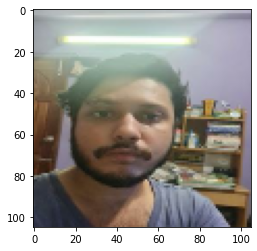

In [ ]:
plt.imshow(img)


In [ ]:
tf.shape(img).numpy()

array([105, 105,   3], dtype=int32)

In [ ]:
converted = tf.image.rgb_to_grayscale(img)

In [ ]:
tf.shape(converted).numpy()

array([105, 105,   1], dtype=int32)

# 3.3 Create Labelled Dataset

In [ ]:
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data= positives.concatenate(negatives)

In [ ]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [ ]:
tf.ones(len(anchor))

<tf.Tensor: shape=(199,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
dataset=tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))
list(dataset.as_numpy_iterator())

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [ ]:
sample= data.as_numpy_iterator()
example=sample.next()

# 3.4 Build Train and Test Partition

In [ ]:
def preprocess_twin(input_img,validation_img,label):
  return (preprocess(input_img),preprocess(validation_img),label)

In [ ]:
res = preprocess_twin(*example)

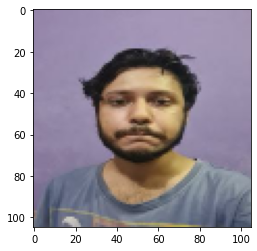

In [ ]:
plt.imshow(res[1])

In [ ]:
#Build dataloader pipeline
data= data.map(preprocess_twin)
data=data.cache()
data=data.shuffle(buffer_size=1024)

In [ ]:
#Training Partition

train_data= data.take(round(len(data)*.7))
train_data= train_data.batch(16)
train_data= train_data.prefetch(8)

In [ ]:
train_data

<PrefetchDataset shapes: ((None, 105, 105, None), (None, 105, 105, None), (None,)), types: (tf.float32, tf.float32, tf.float32)>

In [ ]:
# Testing partition
test_data= data.skip(round(len(data)*.7))
test_data= data.take(round(len(data)*.3))
test_data= test_data.batch(16)
test_data= test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [ ]:
inp =Input(shape=(105,105,3),name='input_image')
print(inp)
c1= Conv2D(64,(10,10), activation='relu')(inp)
print(c1)
m1= MaxPooling2D(64,(2,2), padding='same')(c1)
m1

KerasTensor(type_spec=TensorSpec(shape=(None, 105, 105, 3), dtype=tf.float32, name='input_image'), name='input_image', description="created by layer 'input_image'")
KerasTensor(type_spec=TensorSpec(shape=(None, 96, 96, 64), dtype=tf.float32, name=None), name='conv2d/Relu:0', description="created by layer 'conv2d'")


<KerasTensor: shape=(None, 48, 48, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [ ]:
def make_embedding():

  #First Block
  inp =Input(shape=(105,105,3),name='input_image')
  c1= Conv2D(64,(10,10), activation='relu')(inp)
  m1= MaxPooling2D(64,(2,2), padding='same')(c1)

  #Second Block
  c2= Conv2D(128,(7,7), activation='relu')(m1)
  m2= MaxPooling2D(64,(2,2), padding='same')(c2)

  #Third Block
  c3= Conv2D(128, (4,4), activation='relu')(m2)
  m3= MaxPooling2D(64,(2,2), padding='same')(c3)

  #Final Block
  c4= Conv2D(256,(4,4), activation= 'relu')(m3)
  f1= Flatten()(c4)
  d1= Dense(4096, activation='sigmoid')(f1)


  return Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
embedding=make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 105, 105, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 64)        19264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 128)         0 

## 4.2 Build Distance Layer

In [ ]:
#Siamese L1 distance class
class L1Dist(Layer):
  def __init__(self, **kwargs) :
    super().__init__()

#Similarity Calculation 

  def call(self, input_embedding, validation_embedding):
      return tf.math.abs(input_embedding - validation_embedding)

## 4.3 Make Siamese Model

In [ ]:
input_image= Input(name='input_image', shape=(105,105,3))

In [ ]:
validation_image= Input(name='validation_image', shape=(105,105,3))

In [ ]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [ ]:

siamese_layer = L1Dist()

In [ ]:
distances = siamese_layer(inp_embedding, val_embedding)

In [ ]:
classifier = Dense(1, activation='sigmoid')(distances)

In [ ]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>

In [ ]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
validation_image (InputLayer)   [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_image[0][0]                
                                                                 validation_image[0][0]           
__________________________________________________________________________________________________
l1_dist (L1Dist)                (None, 4096)         0           embedding[0][0]     

In [ ]:
def make_siamese_model():

  #Anchor image in the Neural Network
  input_image= Input(name='input_image', shape=(105,105,3))

  #Validation image in the Neural Network
  validation_image= Input(name='validation_image', shape=(105,105,3))

  #combine siamese distance components
  siamese_layer=L1Dist()
  siamese_layer._name= 'distance'
  distances= siamese_layer(embedding(input_image),embedding(validation_image))

  #Classification Layer
  classifier= Dense(1, activation='sigmoid')(distances)

  return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [ ]:
siamese_model= make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
validation_image (InputLayer)   [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_image[0][0]                
                                                                 validation_image[0][0]           
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

# 5. Training

## 5.1 Setup Loss and Optimizer

In [ ]:
binary_cross_loss= tf.losses.BinaryCrossentropy()

In [ ]:
opt=tf.keras.optimizers.Adam(1e-4)

## 5.2 Establish Checkpoints

In [ ]:
#reload from the checkpoints model.load.('path_to_checkpoint')
#to use pre trained weight

checkpoint_dir="./training_checkpoint"
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [ ]:
@tf.function
def train_step(batch):

  with tf.GradientTape() as tape:
    # Get anchor and positive/negative image
    X=batch[:2]
    #Get label
    y=batch[2]

    #Forward pass
    yhat= siamese_model(X, training=True)
    #calculate loss
    loss= binary_cross_loss(y,yhat)

    #calculate gradient
    grad= tape.gradient(loss,siamese_model.trainable_variables)

    #calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))



In [ ]:
test_batch = train_data.as_numpy_iterator()

In [ ]:
batch_1 = test_batch.next()

In [ ]:
X = batch_1[:2]

In [ ]:
y = batch_1[2]

In [ ]:
y

array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
      dtype=float32)

## 5.4 Build Training Loop

In [ ]:
def train(train_data, EPOCHS):
  # Loop through each epoch
  for epoch in range (1, EPOCHS+1):
    print('\n Epoch {}/{}'.format(epoch,EPOCHS))
    progbar= tf.keras.utils.Progbar(len(train_data))

    #Loop through each batch
    for idx,batch in enumerate(train_data):
      #Run train step here
      train_step(batch)
      progbar.update(idx+1)

    #save checkpoints
    if epoch%10 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)


## 5.5 Train the model

In [ ]:
EPOCHS=50

In [ ]:
train(train_data,EPOCHS)


 Epoch 1/50
18/18 [==============================] - 15s 222ms/step

 Epoch 2/50
18/18 [==============================] - 3s 198ms/step

 Epoch 3/50
18/18 [==============================] - 3s 200ms/step

 Epoch 4/50
18/18 [==============================] - 3s 199ms/step

 Epoch 5/50
18/18 [==============================] - 3s 199ms/step

 Epoch 6/50
18/18 [==============================] - 3s 200ms/step

 Epoch 7/50
18/18 [==============================] - 4s 201ms/step

 Epoch 8/50
18/18 [==============================] - 4s 201ms/step

 Epoch 9/50
18/18 [==============================] - 4s 201ms/step

 Epoch 10/50
18/18 [==============================] - 3s 200ms/step

 Epoch 11/50
18/18 [==============================] - 4s 209ms/step

 Epoch 12/50
18/18 [==============================] - 3s 200ms/step

 Epoch 13/50
18/18 [==============================] - 4s 200ms/step

 Epoch 14/50
18/18 [==============================] - 4s 201ms/step

 Epoch 15/50
18/18 [=====================

# 6. Evaluate Model

###Import Matrics

In [ ]:
#Import Precision and Recall
from tensorflow.keras.metrics import Precision, Recall

### Make Predictions

In [ ]:
#Get a batch of test data
test_input, test_val, y_true= test_data.as_numpy_iterator().next()

In [ ]:
#Make Prediction
y_hat= siamese_model.predict([test_input,test_val])
y_hat

array([[9.9999785e-01],
       [9.9999642e-01],
       [4.4251388e-04],
       [9.9998271e-01],
       [2.2232820e-07],
       [9.3910887e-05],
       [7.7189989e-06],
       [4.6459568e-06],
       [9.9992752e-01],
       [9.9980146e-01],
       [9.9999988e-01],
       [2.6236311e-08],
       [5.6186423e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9970031e-01]], dtype=float32)

In [ ]:
#Post processing the result
[1 if prediction>0.5 else 0 for prediction in y_hat]

[1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1]

In [ ]:
y_true

array([1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1.],
      dtype=float32)

###Calculating Metrics

In [ ]:
#Calculate Recall

m= Recall()

#Calculating the Recall Value

m.update_state(y_true,y_hat)

#Return Recall Result
m.result().numpy()

1.0

In [ ]:
# Calculate Precision

m= Precision()
m.update_state(y_true,y_hat)
m.result().numpy()

1.0

###Visualize Result

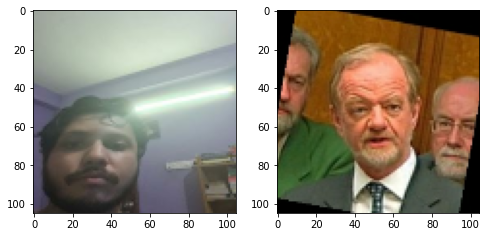

In [ ]:
plt.figure(figsize=(8,8))

#Set first Subplot
plt.subplot(1,2,1)
plt.imshow(test_input[6])
#Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[6])
plt.show()

# 7. Save Model

In [ ]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [ ]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[9.9999785e-01],
       [9.9999642e-01],
       [4.4251388e-04],
       [9.9998271e-01],
       [2.2232820e-07],
       [9.3910887e-05],
       [7.7189989e-06],
       [4.6459568e-06],
       [9.9992752e-01],
       [9.9980146e-01],
       [9.9999988e-01],
       [2.6236311e-08],
       [5.6186423e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9970031e-01]], dtype=float32)

# 8. Real Time Test